# Per-pathway connection probability model building of the whole SSCx circuit
## Preparation of neuron tables and adjacency matrices per pathway

In [1]:
# Global imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sps
import os
import sys
import logging
import pickle
import progressbar

# Local imports
sys.path.append('../../library')
import modelling

In [2]:
save_path = './modelling'
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Mid-range connectivity

In [45]:
data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
conn_fn = 'intra_SSCX_midrange_wm.npz'
nrn_fn = 'neuron_info_extended.feather'
conn_type = 'midrange'

In [3]:
# Load connectivity matrix and neuron table
adj_matrix = sps.load_npz(os.path.join(data_path, conn_fn))
nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))
assert adj_matrix.shape[0] == adj_matrix.shape[1] == nrn_table.shape[0], 'ERROR: Data size mismatch!'
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')

INFO: Loaded connectivity and properties of 4234929 neurons


In [106]:
# Extract neuron tables per m-type
nrn_path = os.path.join(save_path, 'nrn_tables', conn_type)
if not os.path.exists(nrn_path):
    os.makedirs(nrn_path)

mtypes = np.unique(nrn_table['mtype'])
print(f'Found {len(mtypes)} m-types: {mtypes[0]}, ..., {mtypes[-1]}', flush=True)
np.save(os.path.join(nrn_path, 'mtypes.npy'), mtypes.astype(str))

pbar = progressbar.ProgressBar()
for idx in pbar(range(len(mtypes))):
    nrn_table_sel = nrn_table[nrn_table['mtype'] == mtypes[idx]]
    nrn_table_sel.reset_index().to_feather(os.path.join(nrn_path, f'nrn_info__{mtypes[idx]}.feather'))


Found 60 m-types: L1_DAC, ..., L6_UPC


100% |########################################################################|


In [61]:
# Extract sub-matrices per pathway (PRE m-types x POST m-types)
mat_path = os.path.join(save_path, 'adj_matrices', conn_type)
if not os.path.exists(mat_path):
    os.makedirs(mat_path)

adj_sizes = np.full((len(mtypes), len(mtypes), 2), -1)
conn_counts = np.full((len(mtypes), len(mtypes)), -1)

pbar = progressbar.ProgressBar()
for src_idx in pbar(range(len(mtypes))):
    nrn_sel_src = nrn_table[nrn_table['mtype'] == mtypes[src_idx]].index
    for tgt_idx in range(len(mtypes)):
        nrn_sel_tgt = nrn_table[nrn_table['mtype'] == mtypes[tgt_idx]].index
        adj_matrix_pathway = adj_matrix[nrn_sel_src, :][:, nrn_sel_tgt]

        adj_sizes[src_idx, tgt_idx, :] = adj_matrix_pathway.shape
        conn_counts[src_idx, tgt_idx] = adj_matrix_pathway.count_nonzero()

        sps.save_npz(os.path.join(mat_path, f'adj_mat__{mtypes[src_idx]}-{mtypes[tgt_idx]}'), adj_matrix_pathway)

np.save(os.path.join(mat_path, 'adj_sizes.npy'), adj_sizes)
np.save(os.path.join(mat_path, 'conn_counts.npy'), conn_counts)

Found 60 m-types: L1_DAC, ..., L6_UPC


100% |########################################################################|


In [79]:
# Check counts
assert np.sum(conn_counts == -1) == 0, 'ERROR: Connection counts missing!'
assert np.sum(adj_sizes == -1) == 0, 'ERROR: Matrix sizes missing!'
assert np.sum(conn_counts) == adj_matrix.count_nonzero(), 'ERROR: Connection count mismatch!'
assert np.sum(np.prod(adj_sizes, 2)) == np.prod(adj_matrix.shape), 'ERROR: Matrix size mismatch!'
print('INFO: Counts OK!')

INFO: Counts OK!


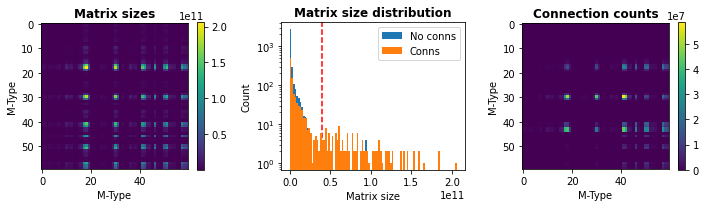

In [213]:
# Show matrix sizes and connection counts
size_lim = 200000**2 # Size limit tested successfully
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(np.prod(adj_sizes, 2), interpolation='nearest')
plt.xlabel('M-Type')
plt.ylabel('M-Type')
plt.title('Matrix sizes', fontweight='bold')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.hist(np.prod(adj_sizes, 2).flatten(), bins=100, log=True, label='No conns')
plt.hist(np.prod(adj_sizes, 2)[conn_counts > 0].flatten(), bins=100, log=True, label='Conns')
# size_hist = np.histogram(np.prod(adj_sizes, 2), bins=100)
# step_size = np.min(np.diff(size_hist[1]))
# # plt.plot(size_hist[1][1:] - step_size, size_hist[0])
# plt.plot(size_hist[1][1:] - step_size, np.cumsum(size_hist[0]))
plt.ylim(plt.ylim()) # Freeze limit
plt.plot([size_lim] * 2, plt.ylim(), '--r', zorder=0)
plt.xlabel('Matrix size')
plt.ylabel('Count')
plt.title('Matrix size distribution', fontweight='bold')
plt.legend()
plt.subplot(1, 3, 3)
plt.imshow(conn_counts, interpolation='nearest')
plt.xlabel('M-Type')
plt.ylabel('M-Type')
plt.title('Connection counts', fontweight='bold')
plt.colorbar()
plt.tight_layout()
plt.show()

In [221]:
max_idx = np.unravel_index(np.argmax(np.prod(adj_sizes, 2)), adj_sizes.shape[:2])
print(f'Max. size: {mtypes[max_idx[0]]}-{mtypes[max_idx[1]]}: {adj_sizes[max_idx[0], max_idx[1], 0]}x{adj_sizes[max_idx[0], max_idx[1], 1]} = {np.prod(adj_sizes[max_idx[0], max_idx[1], :])}')

max_idx = np.unravel_index(np.argmax(conn_counts), adj_sizes.shape[:2])
print(f'Max. conn. count: {mtypes[max_idx[0]]}-{mtypes[max_idx[1]]}: {conn_counts[max_idx[0], max_idx[1]]}')

print(f'Pathways w/o connections: {np.sum(conn_counts == 0)} of {np.sum(conn_counts >= 0)} ({100 * np.sum(conn_counts == 0) / np.sum(conn_counts >= 0)}%)')

Max. size: L3_TPC:A-L3_TPC:A: 453858x453858 = 205987084164
Max. conn. count: L4_TPC-L5_TPC:A: 58568344
Pathways w/o connections: 2520 of 3600 (70.0%)


In [224]:
# Extract sub-matrices per pathway (PRE m-types x All POST)
mat_path = os.path.join(save_path, 'adj_matrices', conn_type)
if not os.path.exists(mat_path):
    os.makedirs(mat_path)

adj_sizes = np.full((len(mtypes), 2), -1)
conn_counts = np.full(len(mtypes), -1)

pbar = progressbar.ProgressBar()
for src_idx in pbar(range(len(mtypes))):
    nrn_sel_src = nrn_table[nrn_table['mtype'] == mtypes[src_idx]].index
    adj_matrix_pathway = adj_matrix[nrn_sel_src, :]

    adj_sizes[src_idx, :] = adj_matrix_pathway.shape
    conn_counts[src_idx] = adj_matrix_pathway.count_nonzero()

    sps.save_npz(os.path.join(mat_path, f'adj_mat__{mtypes[src_idx]}-ALL'), adj_matrix_pathway)

np.save(os.path.join(mat_path, 'adj_sizes_PRE.npy'), adj_sizes)
np.save(os.path.join(mat_path, 'conn_counts_PRE.npy'), conn_counts)

100% |########################################################################|


In [227]:
max_idx = np.argmax(np.prod(adj_sizes, 1))
print(f'Max. size: {mtypes[max_idx]}-ALL: {adj_sizes[max_idx, 0]}x{adj_sizes[max_idx, 1]} = {np.prod(adj_sizes[max_idx, :])}')

max_idx = np.argmax(conn_counts)
print(f'Max. conn. count: {mtypes[max_idx]}-ALL: {conn_counts[max_idx]}')

print(f'Pathways w/o connections: {np.sum(conn_counts == 0)} of {np.sum(conn_counts >= 0)} ({100 * np.sum(conn_counts == 0) / np.sum(conn_counts >= 0)}%)')

Max. size: L3_TPC:A-ALL: 453858x4234929 = 1922056406082
Max. conn. count: L4_TPC-ALL: 385285691
Pathways w/o connections: 42 of 60 (70.0%)


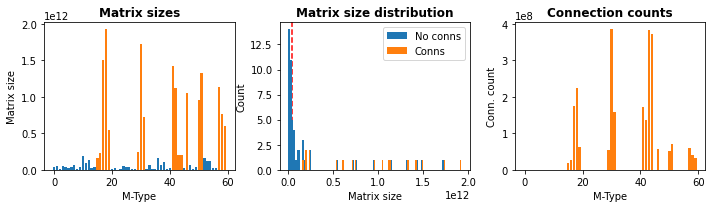

In [229]:
# Show matrix sizes and connection counts
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.bar(np.arange(len(mtypes)), np.prod(adj_sizes, 1), label='No conns')
plt.bar(np.arange(len(mtypes))[conn_counts > 0], np.prod(adj_sizes, 1)[conn_counts > 0], label='Conns')
plt.xlabel('M-Type')
plt.ylabel('Matrix size')
plt.title('Matrix sizes', fontweight='bold')
plt.subplot(1, 3, 2)
plt.hist(np.prod(adj_sizes, 1), bins=100, log=False, label='No conns')
plt.hist(np.prod(adj_sizes, 1)[conn_counts > 0], bins=100, log=False, label='Conns')
plt.ylim(plt.ylim()) # Freeze limit
plt.plot([size_lim] * 2, plt.ylim(), '--r', zorder=0)
plt.xlabel('Matrix size')
plt.ylabel('Count')
plt.title('Matrix size distribution', fontweight='bold')
plt.legend()
plt.subplot(1, 3, 3)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.xlabel('M-Type')
plt.ylabel('Conn. count')
plt.title('Connection counts', fontweight='bold')
plt.tight_layout()
plt.show()

### Local connectivity

In [3]:
data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
conn_fn = 'local_connectivity.npz'
nrn_fn = 'neuron_info.feather'
conn_type = 'local'

In [4]:
# Load connectivity matrix and neuron table
adj_matrix = sps.load_npz(os.path.join(data_path, conn_fn))
nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))
assert adj_matrix.shape[0] == adj_matrix.shape[1] == nrn_table.shape[0], 'ERROR: Data size mismatch!'
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')

INFO: Loaded connectivity and properties of 4234929 neurons


In [6]:
# Extract neuron tables per m-type
nrn_path = os.path.join(save_path, 'nrn_tables', conn_type)
if not os.path.exists(nrn_path):
    os.makedirs(nrn_path)

mtypes = np.unique(nrn_table['mtype'])
print(f'Found {len(mtypes)} m-types: {mtypes[0]}, ..., {mtypes[-1]}', flush=True)
np.save(os.path.join(nrn_path, 'mtypes.npy'), mtypes.astype(str))

pbar = progressbar.ProgressBar()
for idx in pbar(range(len(mtypes))):
    nrn_table_sel = nrn_table[nrn_table['mtype'] == mtypes[idx]]
    nrn_table_sel.reset_index().to_feather(os.path.join(nrn_path, f'nrn_info__{mtypes[idx]}.feather'))

Found 60 m-types: L1_DAC, ..., L6_UPC


100% |########################################################################|


In [7]:
# Extract sub-matrices per pathway (PRE m-types x All POST)
mat_path = os.path.join(save_path, 'adj_matrices', conn_type)
if not os.path.exists(mat_path):
    os.makedirs(mat_path)

adj_sizes = np.full((len(mtypes), 2), -1)
conn_counts = np.full(len(mtypes), -1)

pbar = progressbar.ProgressBar()
for src_idx in pbar(range(len(mtypes))):
    nrn_sel_src = nrn_table[nrn_table['mtype'] == mtypes[src_idx]].index
    adj_matrix_pathway = adj_matrix[nrn_sel_src, :]

    adj_sizes[src_idx, :] = adj_matrix_pathway.shape
    conn_counts[src_idx] = adj_matrix_pathway.count_nonzero()

    sps.save_npz(os.path.join(mat_path, f'adj_mat__{mtypes[src_idx]}-ALL'), adj_matrix_pathway)

np.save(os.path.join(mat_path, 'adj_sizes_PRE.npy'), adj_sizes)
np.save(os.path.join(mat_path, 'conn_counts_PRE.npy'), conn_counts)

100% |########################################################################|


In [8]:
max_idx = np.argmax(np.prod(adj_sizes, 1))
print(f'Max. size: {mtypes[max_idx]}-ALL: {adj_sizes[max_idx, 0]}x{adj_sizes[max_idx, 1]} = {np.prod(adj_sizes[max_idx, :])}')

max_idx = np.argmax(conn_counts)
print(f'Max. conn. count: {mtypes[max_idx]}-ALL: {conn_counts[max_idx]}')

print(f'Pathways w/o connections: {np.sum(conn_counts == 0)} of {np.sum(conn_counts >= 0)} ({100 * np.sum(conn_counts == 0) / np.sum(conn_counts >= 0)}%)')

Max. size: L3_TPC:A-ALL: 453858x4234929 = 1922056406082
Max. conn. count: L3_TPC:A-ALL: 291308690
Pathways w/o connections: 0 of 60 (0.0%)


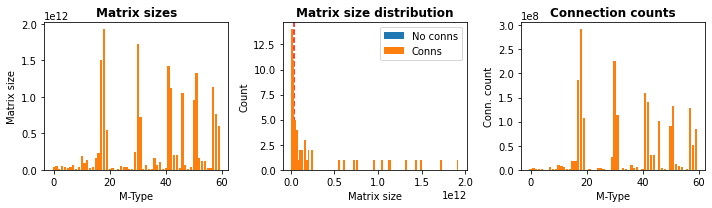

In [10]:
# Show matrix sizes and connection counts
size_lim = 200000**2 # Size limit tested successfully
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.bar(np.arange(len(mtypes)), np.prod(adj_sizes, 1), label='No conns')
plt.bar(np.arange(len(mtypes))[conn_counts > 0], np.prod(adj_sizes, 1)[conn_counts > 0], label='Conns')
plt.xlabel('M-Type')
plt.ylabel('Matrix size')
plt.title('Matrix sizes', fontweight='bold')
plt.subplot(1, 3, 2)
plt.hist(np.prod(adj_sizes, 1), bins=100, log=False, label='No conns')
plt.hist(np.prod(adj_sizes, 1)[conn_counts > 0], bins=100, log=False, label='Conns')
plt.ylim(plt.ylim()) # Freeze limit
plt.plot([size_lim] * 2, plt.ylim(), '--r', zorder=0)
plt.xlabel('Matrix size')
plt.ylabel('Count')
plt.title('Matrix size distribution', fontweight='bold')
plt.legend()
plt.subplot(1, 3, 3)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.xlabel('M-Type')
plt.ylabel('Conn. count')
plt.title('Connection counts', fontweight='bold')
plt.tight_layout()
plt.show()